In [1]:
using Images
using Statistics
using PythonPlot
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology
mpl = PythonPlot.pyimport("matplotlib")
mpl.rcParams["svg.fonttype"] = "none"

"none"

In [2]:
function mask_site(file, threshold; n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [3]:
# Modified for mutli-signal to return times instead of time-crops
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    start = Integer(findall(signal .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

In [4]:
# Modified for mutli-signal to return times instead of time-crops
# Smooth signal for finding half-max time to exclude noisy peaks
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    smoothed = (signal[1:end-2] + signal[2:end-1] + signal[3:end]) / 3
    start = Integer(findall(smoothed .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

Loading: 100%|███████████████████████████████████████████| Time: 0:00:01


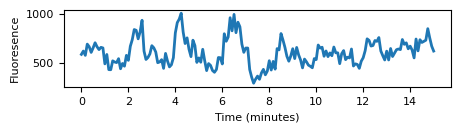

163:343

In [5]:
file = "../data/2024_10_10-3XGBwt/crops/movie3-cell21.tif"
interval = 5
time_threshold=0.45
masks = mask_site(file, 0.5, n_sites=1);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
q1 = vquantile(m1, (im_size-1)/im_size, dims=(1,2))[1,1,:]
q3 = vquantile(m1, (im_size-3)/im_size, dims=(1,2))[1,1,:]
q5 = vquantile(m1, (im_size-5)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
print(times_max1)
crop1 = q1[times_max1]
crop3 = q3[times_max1]
crop5 = q5[times_max1]
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes

crop1 =  maximum(m1, dims=(1,2))[1,1,times_max1]

fig, ax = subplots(figsize=(5,1))
ax.plot(t, crop1, linewidth=2, color="C0")
ax.set_ylabel("Fluoresence", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)

savefig("../figures/trace1-wt.svg")
display(gcf())

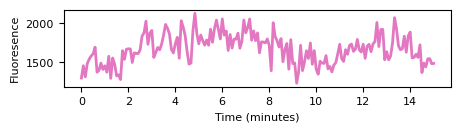

74:254

In [12]:
file = "../data/2024_10_10-3XGBpak1/crops/movie10_cell20.tif"
interval = 5
time_threshold=0.5
masks = mask_site(file, 0.3, n_sites=1);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
q1 = maximum(m1, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
print(times_max1)
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
crop1 = q1[times_max1]

fig, ax = subplots(figsize=(5,1))
ax.plot(t, crop1, linewidth=2, color="C6")
ax.set_ylabel("Fluoresence", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)

savefig("../figures/trace1-del.svg")
display(gcf())

In [16]:
dir = "../data/2024_10_10-3XGBwt/crops/"
wt_files = readdir(dir)
all_cor = zeros(91, ((length(wt_files))))
t_cor = range(0,90)*(5/60)
peaks_ac = zeros(length(wt_files))
n = 0
cov_threshold = 0.5
max_powers=zeros(95)
frequencies = 0
I_wt = zeros(length(wt_files))
diff_wt = zeros(length(wt_files))
for f in wt_files
    n+=1
    patches = mask_site("$dir$f", cov_threshold, n_sites=1)
    patch1 = patches[:,:,:,1]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    crop1 = max_patch1[times_max1]

    fig, ax = subplots(figsize=(2.5,0.5))
    ax.plot(t, crop1, linewidth=2, color="C0")
    ax.tick_params(left = false, right = false , labelleft = false, labelbottom = false, bottom = false) 

    cell = replace(f,".tif" => "")
    savefig("../figures/naked_traces/wt/wt_$cell.svg", transparent=true)

    pdg_max = DSP.Periodograms.periodogram(crop1)
    max_powers = max_powers .+ pdg_max.power
    frequencies = pdg_max.freq
    #ac
    ac = crosscor(crop1, crop1, 0:90)
    all_cor[:,n] = ac
    I_wt[n] = mean(crop1)
    diff_wt[n] = mean(crop1[1:end-1] .- crop1[2:end])
    mac = findlocalmaxima(ac, window=(3,), edges=false)
    if length(mac) < 1
        continue
    else
        mac = mac[1]
        peaks_ac[n] = mac[1] * (5/60)
    end
end

.....

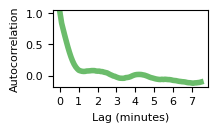

In [22]:
fig, ax = subplots(figsize=(2,1))
ax.plot(t_cor, mean(all_cor,dims=(2)), color="C02", linewidth=4, alpha=0.7)
ax.set_ylabel("Autocorrelation", fontsize=8)
ax.set_xlabel("Lag (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

savefig("../figures/avg_ac_wt.svg")
display(gcf())

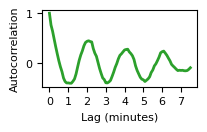

In [47]:
file = "../data/2024_10_10-3XGBwt/crops/movie3-cell21.tif"
m = mask_site(file, cov_threshold, n_sites=1)
max_patch = maximum(m, dims=(1,2))[1,1,:]
times_max = crop_times(max_patch, 15*(60/5), 0.5)
crop = max_patch[times_max]
ac = crosscor(crop, crop, 0:90)


fig, ax = subplots(figsize=(2,1))
ax.plot(t_cor, ac, color="C02", linewidth=2)
ax.set_ylabel("Autocorrelation", fontsize=8)
ax.set_xlabel("Lag (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

savefig("../figures/m3c21_ac1.svg")
display(gcf())

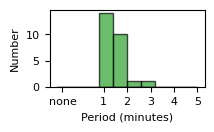

1.467948717948718

Python: None

In [26]:
peaks = filter(x -> x>0.0 && x<5,peaks_ac)
nonpeaks = filter(x -> x==0.0 || x>5,peaks_ac) .- 1

fig, ax = subplots(figsize=(2,1))
ax.hist(peaks, color="C02", alpha=0.7, bins=-1:0.6:5, edgecolor="black")
ax.hist(nonpeaks, color="C03", bins=-1:0.5:5, edgecolor="black")
ax.set_ylabel("Number", fontsize=8)
ax.set_xlabel("Period (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([-0.75,1,2,3,4,5], ["none",1,2,3,4,5])
#ax.vlines(mean(peaks), 0, 12, color="black", linestyle="--")
print(mean(peaks))

display(gcf())

savefig("../figures/wt_ac_histogram.svg")

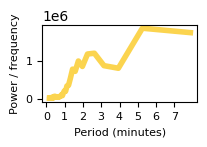

In [30]:

fig, ax = subplots(figsize=(2,1))
ax.plot(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n, color="xkcd:goldenrod", linewidth=4, alpha=0.7)
ax.set_ylabel("Power / frequency", fontsize=8)
ax.set_xlabel("Period (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

savefig("../figures/wt_avg_pdg.svg")
display(gcf())

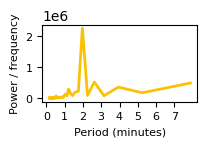

Python: None

In [35]:
pdg = DSP.Periodograms.periodogram(crop)
powers = pdg.power
fig, ax = subplots(figsize=(2,1))
ax.plot(1 ./ frequencies[3:end] .* (5/60), powers[3:end], color="xkcd:goldenrod", linewidth=2)
ax.set_ylabel("Power / frequency", fontsize=8)
ax.set_xlabel("Period (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])
display(gcf())
savefig("../figures/m3c21_pdg1.svg")

In [37]:
dir = "../data/2024_10_10-3XGBpak1/crops/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(91, ((length(wt_files))))
peaks_ac = zeros(length(wt_files))
t_cor = range(0,90)*(5/60)
I_del = zeros(length(wt_files))
diff_del = zeros(length(wt_files))
n = 0
cov_threshold = 0.5
max_powers=zeros(95)
for f in wt_files
    n+=1
    patches = mask_site("$dir$f", cov_threshold, n_sites=1)
    patch1 = patches[:,:,:,1]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    crop1 = max_patch1[times_max1]

    fig, ax = subplots(figsize=(2.5,0.5))
    ax.plot(t, crop1, linewidth=2, color="C06")
    ax.tick_params(left = false, right = false , labelleft = false, labelbottom = false, bottom = false) 

    cell = replace(f,".tif" => "")
    savefig("../figures/naked_traces/pak1/pak1_$cell.svg", transparent=true)

    pdg_max = DSP.Periodograms.periodogram(crop1)
    max_powers = max_powers .+ pdg_max.power
    frequencies = pdg_max.freq
    #ac
    ac = crosscor(crop1, crop1, 0:90)
    all_cor[:,n] = ac
    k = Kernel.gaussian((2,))
    ac = imfilter(ac, k)
    mac = findlocalmaxima(ac, window=(3,), edges=false)
    I_del[n] = mean(crop1)
    diff_del[n] = mean(crop1[1:end-1] .- crop1[2:end])
    if length(mac) < 1
        continue
    else
        mac = mac[1]
        peaks_ac[n] = mac[1] * (5/60)
    end
end

....

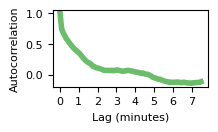

In [39]:
fig, ax = subplots(figsize=(2,1))
ax.plot(t_cor, mean(all_cor,dims=(2)), color="C02", linewidth=4, alpha=0.7)
ax.set_ylabel("Autocorrelation", fontsize=8)
ax.set_xlabel("Lag (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

savefig("../figures/avg_ac_pak1.svg")
display(gcf())

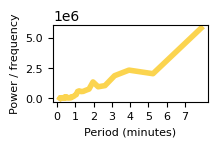

In [41]:

fig, ax = subplots(figsize=(2,1))
ax.plot(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n, color="xkcd:goldenrod", linewidth=4, alpha=0.7)
ax.set_ylabel("Power / frequency", fontsize=8)
ax.set_xlabel("Period (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

savefig("../figures/pak1_avg_pdg.svg")
display(gcf())

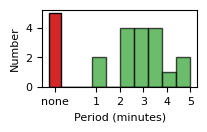

3.053921568627451

Python: None

In [44]:
peaks = filter(x -> x>0.0 && x<5,peaks_ac)
nonpeaks = filter(x -> x==0.0 || x>5,peaks_ac)
nonpeaks = zeros(length(nonpeaks)) .- 1

fig, ax = subplots(figsize=(2,1))
ax.hist(peaks, color="C02", alpha=0.7, bins=-1:0.6:5, edgecolor="black")
ax.hist(nonpeaks, color="C03", bins=-1:0.5:5, edgecolor="black")
ax.set_ylabel("Number", fontsize=8)
ax.set_xlabel("Period (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([-0.75,1,2,3,4,5], ["none",1,2,3,4,5])
#ax.vlines(mean(peaks), 0, 12, color="black", linestyle="--")
print(mean(peaks))

display(gcf())

savefig("../figures/pak1_ac_histogram.svg")

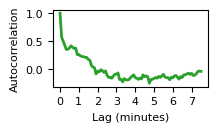

In [48]:
file = "../data/2024_10_10-3XGBpak1/crops/movie10_cell20.tif"
m = mask_site(file, cov_threshold, n_sites=1)
max_patch = maximum(m, dims=(1,2))[1,1,:]
times_max = crop_times(max_patch, 15*(60/5), 0.5)
crop = max_patch[times_max]
ac = crosscor(crop, crop, 0:90)


fig, ax = subplots(figsize=(2,1))
ax.plot(t_cor, ac, color="C02", linewidth=2)
ax.set_ylabel("Autocorrelation", fontsize=8)
ax.set_xlabel("Lag (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

savefig("../figures/m10c20_ac_del.svg")
display(gcf())

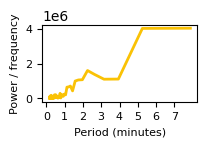

Python: None

In [49]:
pdg = DSP.Periodograms.periodogram(crop)
powers = pdg.power
fig, ax = subplots(figsize=(2,1))
ax.plot(1 ./ frequencies[3:end] .* (5/60), powers[3:end], color="xkcd:goldenrod", linewidth=2)
ax.set_ylabel("Power / frequency", fontsize=8)
ax.set_xlabel("Period (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])
display(gcf())
savefig("../figures/m10c20_pdg_del.svg")

In [ ]:
plot(t_cor, mean(all_cor,dims=(2)), x_ticks=0:8, label=false, linewidth=6, color=3, size=(400,250), alpha=0.5, dpi=600,
    xlabel="Lag (minutes)", ylabel="Correlation", margin=5Plots.mm)
file = "../data/2024_10_10-3XGBpak1/crops/movie10_cell20.tif"
m = mask_site(file, cov_threshold, n_sites=1)
max_patch = maximum(m, dims=(1,2))[1,1,:]
times_max = crop_times(max_patch, 15*(60/5), 0.5)
crop = max_patch[times_max]
ac = crosscor(crop, crop, 0:90)
plot!(t_cor, ac, linewidth=2, color=7, label=false)
#savefig("../figures/3xGB_pak1_ac")
plot(t_cor, ac, x_ticks=0:8, label=false, color=3, linewidth=2, size=(400,200), alpha=1,
    xlabel="Lag (minutes)", ylabel="Correlation", dpi=600, margin=5Plots.mm)
savefig("../figures/3xGB_pak1_ac_example")

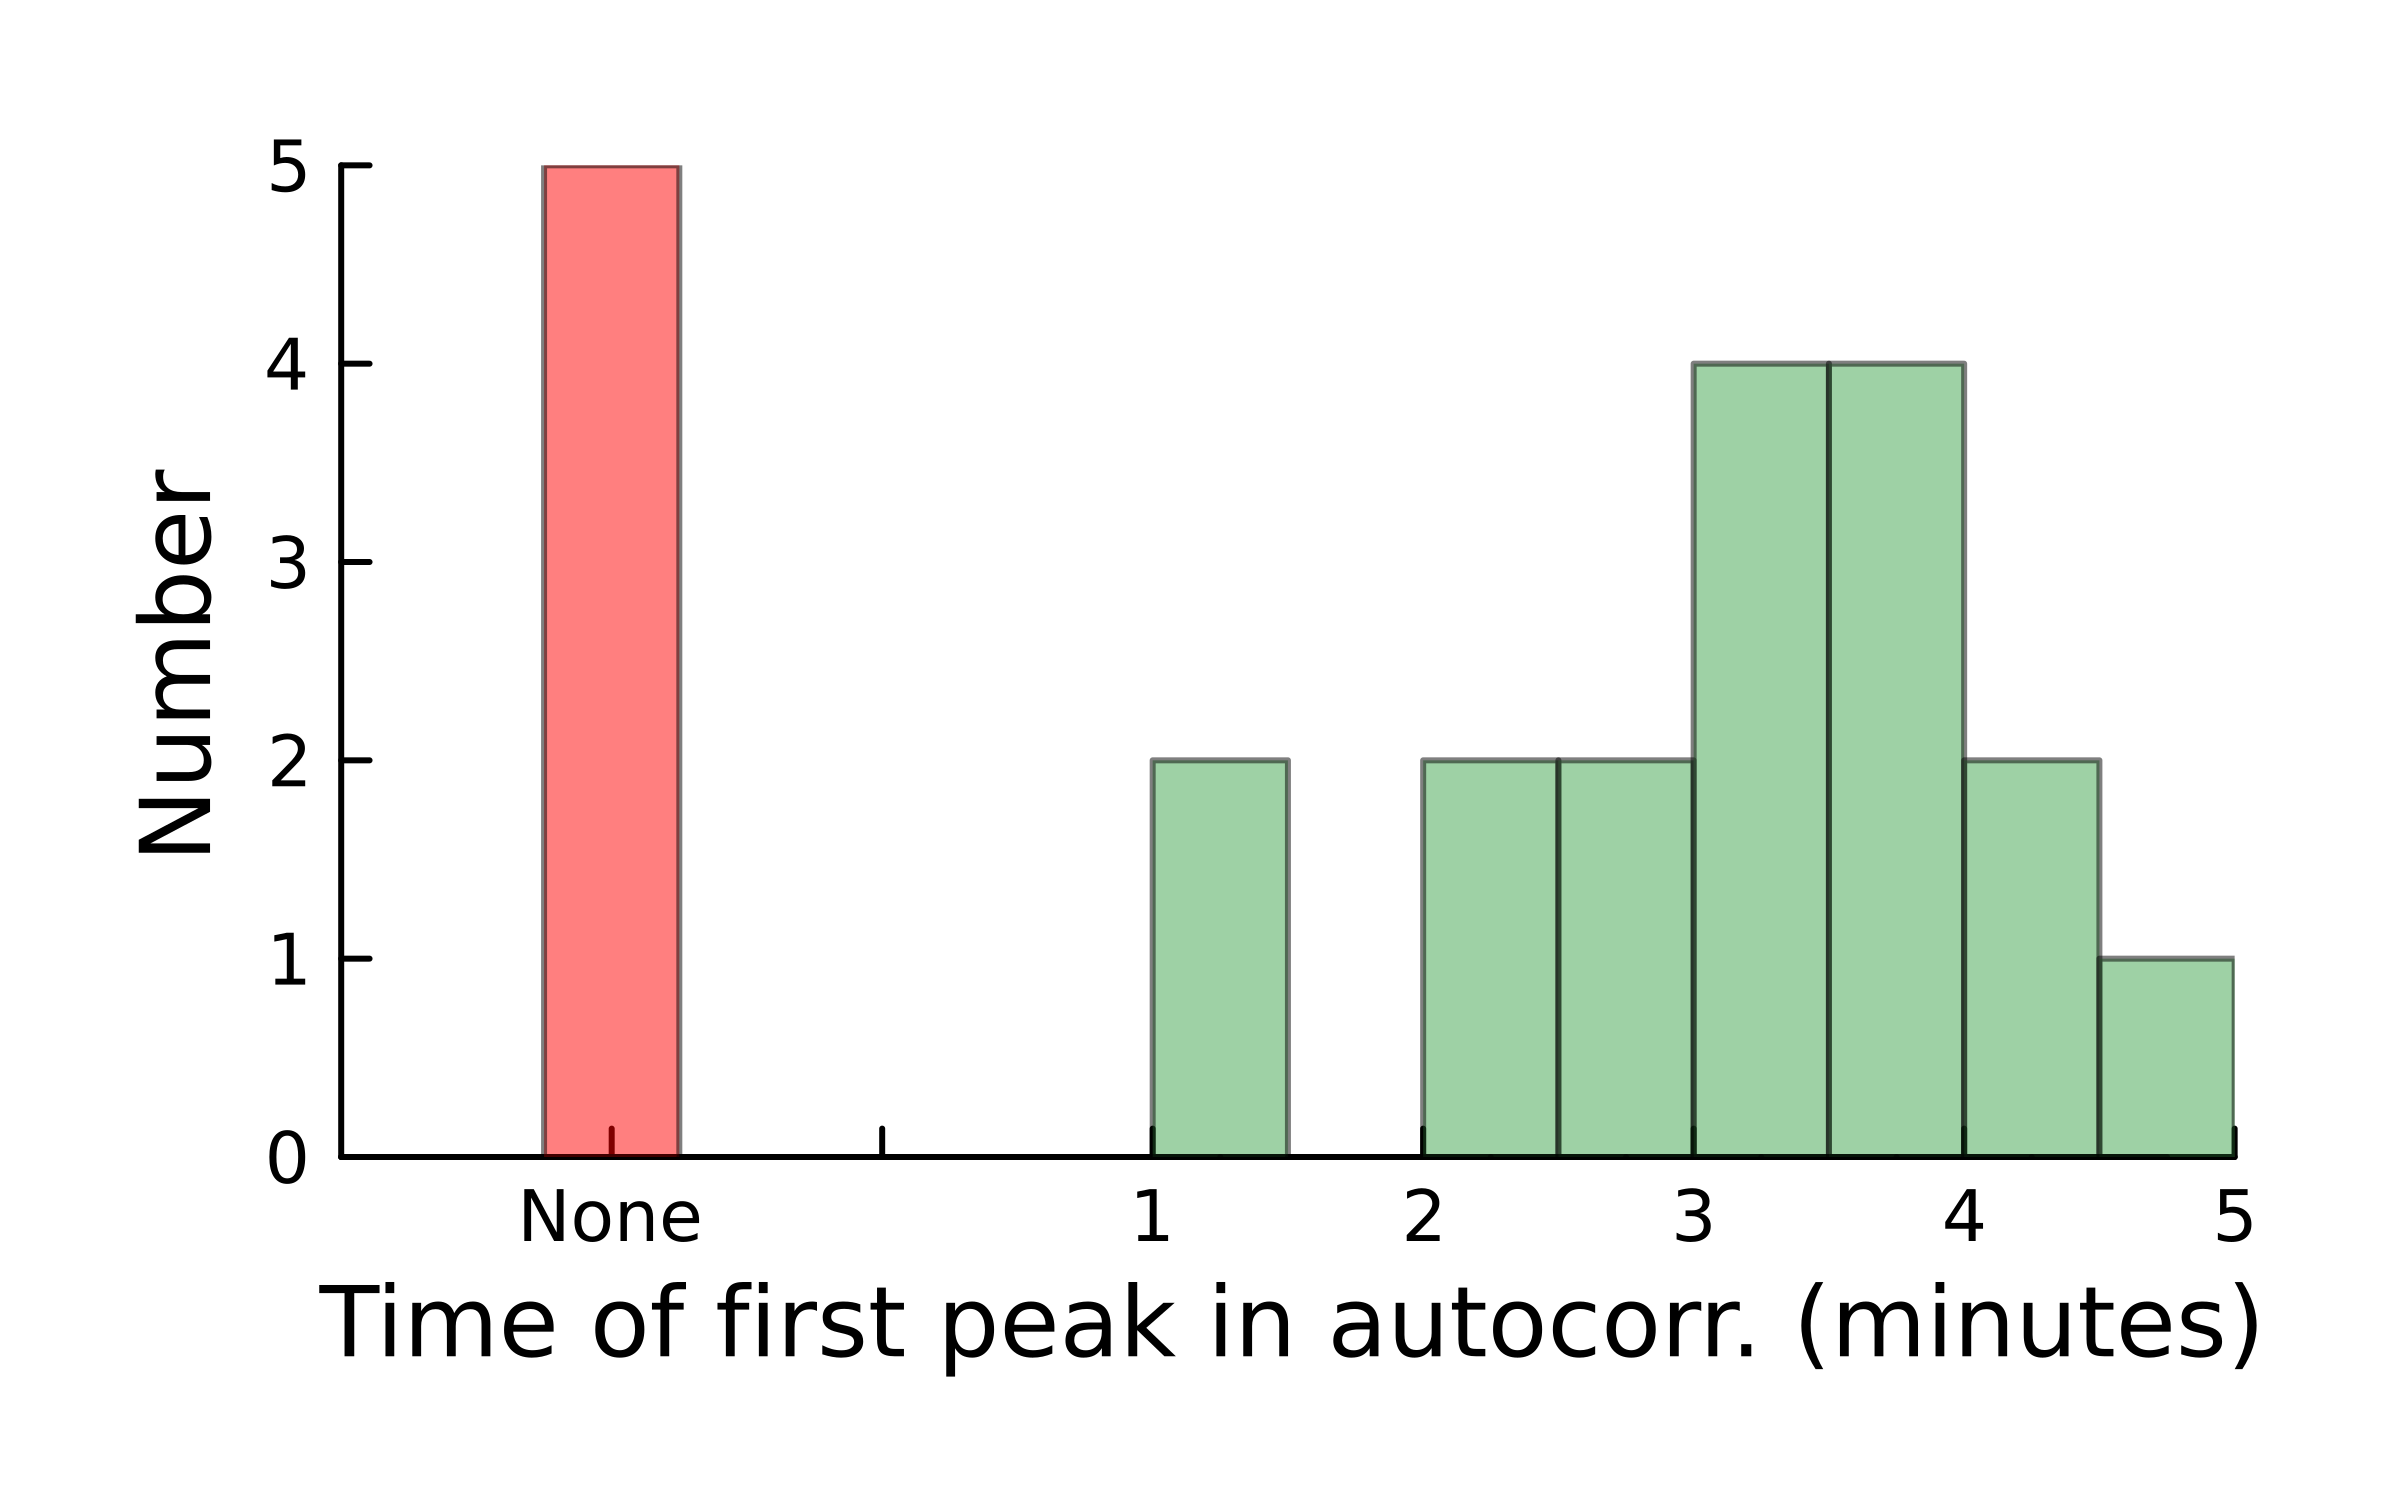

In [404]:
peaks = filter(x -> x>0.0 && x<5,peaks_ac)
nonpeaks = filter(x -> x==0.0 || x>5,peaks_ac)
nonpeaks = zeros(length(nonpeaks)) .-1.25
histogram(peaks, alpha=0.5,bins=0:0.5:5, grid=false, legend=false, xticks=(-1:7, ("None","",1,2,3,4,5)), dpi=600, size=(400,250), color=3,
    xlabel="Time of first peak in autocorr. (minutes)", ylabel="Number", margin=5Plots.mm)
histogram!(nonpeaks, bins=-1.25:0.5:5, alpha=0.5, color="red", xlims=(-2,5))
#savefig("../figures/3xGB_pak1_ac_histogram.png")

In [435]:
plot(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n/10^5, xflip = false, size=(400,250), legend=:bottomright, dpi=600,
    label=false, linewidth=6, alpha=0.5, margin=5Plots.mm, color=5, xlabel="Period (minutes)", ylabel="Power / frequency")
pdg = DSP.Periodograms.periodogram(crop)
powers = pdg.power
plot!(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/10^5, color=7, linewidth=2, label=false)
#savefig("../figures/3xGB_pak1_powers")
plot(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/10^5, color=5, linewidth=2, label=false, 
    size=(400,200), legend=:bottomright,dpi=600, margin=5Plots.mm, xlabel="Period (minutes)", ylabel="Power / frequency")
savefig("../figures/3xGB_pak1_powers_example")

"/home/dinosaur/Lab/Polarity/proj/fig6-deletions/figures/3xGB_pak1_powers_example.png"

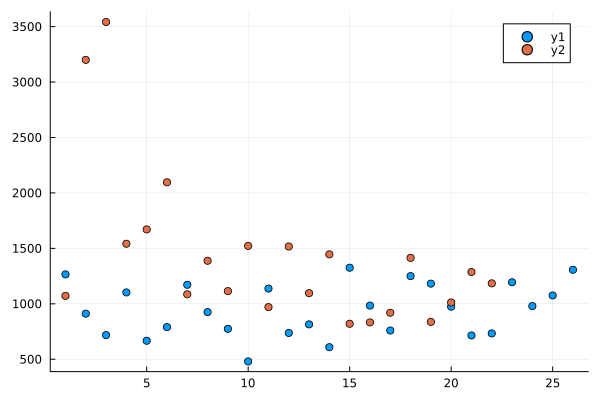

In [295]:
scatter([abs.(I_wt), abs.(I_del)])

In [263]:
diff_wt

26-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0